In [ ]:
!python -m spacy download pt
!python -m spacy download en
!pip install spacy
!pip install beautifulsoup4

  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=27d99777354ad7f149a9dc005e1de844ef1351d9d621490694add09982a5fec6
  Stored in directory: /tmp/pip-ephem-wheel-cache-w7bys376/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
     |████████████████████████████████| 12.0 MB 4.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import nltk
import spacy
from spacy import displacy 
import tqdm
import operator
import requests
from bs4 import BeautifulSoup
import re
import pt_core_news_sm
import en_core_web_sm
from collections import Counter
import random
import operator
import matplotlib.pyplot as plt

# Pos tagging

## Abordagem Manual

Em empresas, quando queremos construir/usar um POS Tagging, estamos buscando uma ferramenta para trabalhar em algum cenário específico e direcionado ao negócio. Por exemplo, recuperar todos os verbos de um texto, para analisar de forma geral as ações que um cliente conecta com a marca no Twitter. Nesse sentido, podemos usar duas abordagens:

    1 - Construir um modelo próprio que resolva esse cenário
    2 - Usar modelos que já existem e, se necessário, treiná-los para melhor performance no nosso cenário

Para esse exercício, vamos simular esse cenário de recuperar verbos de um texto. Apesar da abordagem 2 parecer mais interessante, vamos tentar construir nosso próprio modelo e aprender um pouco sobre a complexidade do problema.

Inicialmente, vamos reduzir bem nosso escopo, focando em

    - REGEX com NamedGoups
    - Verbos simples, como estudar
    
Use o método abaixo para verificar quais grupos foram identificados pela expressão regular:

```python
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})
```

Mais informações de regex: https://docs.python.org/pt-br/3.8/howto/regex.html

In [ ]:
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})

In [ ]:
phrase1 = "eu estudo, você estuda, nós estudamos e vc sabe como é... estudos em todo lugar "

In [ ]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w?\b)'

In [ ]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}


<b> Atividade </b>

1) Modifique o padrão da regex para conseguir reconhecer todas as conjugações do verbo estudar na 'phrase1'

In [ ]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w+?\b)'   # pode ser utilizado para taggear palavras especificas 

In [ ]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}
{'VERB_ESTUDAR': 'estudamos'}
{'VERB_ESTUDAR': 'estudos'}


<b> Atividade </b>

2) A solução da atividade 1 trouxe todos verbos? Todas as palavras eram verbos?  Este método é simples?

Sim. Nem todas as palavras eram verbos, algumas eram suas variações. É um método simples porém muito trabalhoso, pois é necessário escrever uma expressão regular para cada verbo.

## Mac_Morpho com NLTK

In [ ]:
nltk.download('mac_morpho')
print("WORDS ", nltk.corpus.mac_morpho.tagged_words())
print("______________")
print("SENTS ",nltk.corpus.mac_morpho.tagged_sents())

[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.
WORDS  [('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]
______________
SENTS  [[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('em', 'PREP|+'), ('a', 'ART'), ('venda', 'N'), ('de', 'PREP|+'), ('a', 'ART'), ('Pinhal', 'NPROP'), ('em', 'PREP'), ('São', 'NPROP'), ('Paulo', 'NPROP')], [('Programe', 'V'), ('sua', 'PROADJ'), ('viagem', 'N'), ('a', 'PREP|+'), ('a', 'ART'), ('Exposição', 'NPROP'), ('Nacional', 'NPROP'), ('do', 'NPROP'), ('Zebu', 'NPROP'), (',', ','), ('que', 'PRO-KS-REL'), ('começa', 'V'), ('dia', 'N'), ('25', 'N|AP')], ...]


In [ ]:
words_tagged = nltk.corpus.mac_morpho.tagged_words()

In [ ]:
words_tagged

[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]

<b> Atividade </b>

3) Gere a quantidade de itens de cada tag no mac_morpho

In [ ]:
tags = {}
for palavra,tag in words_tagged:
  if tag not in tags:
     tags[tag] = 1
  else:
    tags[tag] += 1
 

In [ ]:
tags

{'!': 919,
 '"': 21069,
 '$': 60,
 "'": 510,
 '(': 7713,
 '((': 10,
 ')': 7741,
 '))': 10,
 ',': 68494,
 '-': 3117,
 '.': 82,
 '...': 84,
 '/': 95,
 ':': 6736,
 ';': 1376,
 '=': 14,
 '?': 1510,
 'ADJ': 53372,
 'ADJ|+': 11,
 'ADJ|EST': 174,
 'ADV': 30653,
 'ADV-KS': 392,
 'ADV-KS-REL': 898,
 'ADV|+': 8,
 'ADV|EST': 9,
 'ADV|HOR': 9,
 'ADV|[': 18,
 'ADV|]': 13,
 'ART': 151891,
 'ART|+': 7,
 'ART|EST': 4,
 'CUR': 2706,
 'IN': 415,
 'IN|EST': 1,
 'KC': 28262,
 'KC|+': 2,
 'KC|EST': 2,
 'KC|[': 143,
 'KC|]': 133,
 'KS': 14320,
 'KS|[': 5,
 'KS|]': 4,
 'N': 236462,
 'NPRO': 3,
 'NPROP': 114318,
 'NPROP|+': 35,
 'NUM': 18110,
 'NUM|TEL': 2,
 'N|AP': 4350,
 'N|DAD': 255,
 'N|DAT': 285,
 'N|EST': 2807,
 'N|HOR': 913,
 'N|TEL': 866,
 'PCP': 23092,
 'PDEN': 6786,
 'PDEN|EST': 2,
 'PREP': 104364,
 'PREP|': 2,
 'PREP|+': 78274,
 'PREP|+]': 7,
 'PREP|EST': 3,
 'PREP|[': 20,
 'PREP|]': 9,
 'PRO-KS': 2150,
 'PRO-KS-REL': 11347,
 'PROADJ': 20919,
 'PROADJ|+': 2,
 'PROP': 7,
 'PROPESS': 14718,
 'PROPESS

4) Quais são as tags mais com maior frequência? E quais com menor? Esse resultado faz sentido?

In [ ]:
tags = sorted(tags.items(), key=operator.itemgetter(1))  # tags ordenadas 

In [ ]:
tags[-5:]   # maior frequencia

[('V', 98056),
 ('PREP', 104364),
 ('NPROP', 114318),
 ('ART', 151891),
 ('N', 236462)]

In [ ]:
tags[:5]   # menor frequencia

[('VAUX|!', 1), ('IN|EST', 1), ('V|!', 1), ('NUM|TEL', 2), ('PREP|', 2)]

As tags mais frequentes tem verbo, preposição, artigo, número nas menos frequentes tem verbo auxiliar junto com exclamação, tem in junto com o est, o v junto com a exclamação por exemplo.

## POS Tagging com Spacy - Desambiguando frases

Uma das aplicações do pos tagging é auxiliar na desambiguação de palavras. Uma mesma palavra pode desempenhar funções semântias diferentes, dependendo do contexto.

<b> Atividade </b>

5) Considere as frases abaixo:

5.1) frases grupo1:
```python
frase0="Ele foi andar"
frase1="O andar estava triste"
```

5.2) frase grupo2:
```python
frase2="Essa cola cola papel"
```
5.3) frases grupo3:
```python
frase3="Hora de fazer imposto de renda"
frase4="Aquilo foi imposto pelo chefe"
```

5.4) frases grupo4:
```python
frase5="Hora de fazer imposto de renda"
frase6="Aquilo foi imposto pelo chefe"
```

5.5) frases grupo5:
```python
frase7="Todo dia eu caminho"
frase8="Esse é o caminho mais fácil"
```

Utilizando o modelo ``pt_core_news_sm`` da biblioteca spacy faça as seguinte análises. Para cada token:

- a) imprima a função sintática (pos-tagging) em texto
- b) relação de dependência sintática em texto
- c) gera uma imagem das relações acims utilizando o método abaixo:
- d) análise a palavra em comum, descreva a diferença sintática encontrada e responda se é gramaticamente correta

```python
#Para imprimir detalhes
displacy.render(doc, style='dep',jupyter=True)

```

Dica: https://spacy.io/api/annotation

In [ ]:
model = pt_core_news_sm.load()

In [ ]:
model

<b> Atividade </b>

5.1 Frases Grupo 1

In [ ]:
txt0="Ele foi andar"
txt1="O andar estava triste"

In [ ]:
def analisa_texto(frase):
  frase_model = model(frase)
  for token in frase_model:
    print('token',token.text,"a) tag", token.pos_, "c)dep=",token.dep_)
  displacy.render(frase_model, style='dep',jupyter=True)

In [ ]:
analisa_texto(txt0)

token Ele a) tag PRON c)dep= nsubj:pass
token foi a) tag AUX c)dep= aux:pass
token andar a) tag VERB c)dep= ROOT


In [ ]:
analisa_texto(txt1)

token O a) tag DET c)dep= det
token andar a) tag NOUN c)dep= nsubj
token estava a) tag VERB c)dep= cop
token triste a) tag ADJ c)dep= ROOT


Identificou corretamente as diferentes formas gramaticais  da palavra andar. Na primeira frase identificada como verbo e na segunda frase como substantivo.

<b> d) Disucussão Grupo 1: </b>

<b> Atividade </b>

5.2. Frase Grupo 2

In [ ]:
txt2="Essa cola cola papel"

In [ ]:
analisa_texto(txt2)

token Essa a) tag DET c)dep= det
token cola a) tag NOUN c)dep= ROOT
token cola a) tag ADJ c)dep= flat:name
token papel a) tag PROPN c)dep= flat:name


A palavra cola repetida na frase foi classificada corretamente de forma diferente como substantivo o produto cola e adjetivo.

<b> d) Disucussão Grupo 2: </b>

<b> Atividade </b>

5.3. Frases Grupo 3

In [ ]:
txt3="Segundo o que me disseram, ele estava triste"
txt4="No segundo dia de trabalho ela gastou menos"

In [ ]:
analisa_texto(txt3)

token Segundo a) tag ADP c)dep= case
token o a) tag PRON c)dep= obl
token que a) tag PRON c)dep= nsubj
token me a) tag PRON c)dep= iobj
token disseram a) tag VERB c)dep= acl:relcl
token , a) tag PUNCT c)dep= punct
token ele a) tag PRON c)dep= nsubj
token estava a) tag VERB c)dep= cop
token triste a) tag ADJ c)dep= ROOT


In [ ]:
analisa_texto(txt4)

token No a) tag ADP c)dep= case
token segundo a) tag ADJ c)dep= amod
token dia a) tag NOUN c)dep= obl
token de a) tag ADP c)dep= case
token trabalho a) tag NOUN c)dep= nmod
token ela a) tag PRON c)dep= nsubj
token gastou a) tag VERB c)dep= ROOT
token menos a) tag ADV c)dep= advmod


Classificou corretamente a palavra segundo pois a palavra tem significado diferente nas frases 3 e 4.

<b> d) Disucussão Grupo 3: </b>

<b> Atividade </b>

5.4. Frases Grupo 4

In [ ]:
txt5="Hora de fazer imposto de renda"
txt6="Aquilo foi imposto pelo chefe"

In [ ]:
analisa_texto(txt5)

token Hora a) tag NOUN c)dep= ROOT
token de a) tag ADP c)dep= mark
token fazer a) tag VERB c)dep= acl
token imposto a) tag NOUN c)dep= obj
token de a) tag ADP c)dep= case
token renda a) tag NOUN c)dep= nmod


In [ ]:
analisa_texto(txt6)

token Aquilo a) tag PRON c)dep= nsubj:pass
token foi a) tag AUX c)dep= aux:pass
token imposto a) tag VERB c)dep= ROOT
token pelo a) tag ADP c)dep= case
token chefe a) tag NOUN c)dep= obl


A palavra imposto da segunda frase foi classificado corretamente como verbo derivada do verbo impor, com sentido diferente do substantivo imposto de renda.


<b> d) Disucussão Grupo 4: </b>

<b> Atividade </b>

5.5. Frases Grupo 5

In [ ]:
txt7="Todo dia eu caminho"
txt8="Esse é o caminho mais fácil"

In [ ]:
analisa_texto(txt7)

token Todo a) tag DET c)dep= det
token dia a) tag NOUN c)dep= obl
token eu a) tag PRON c)dep= nsubj
token caminho a) tag VERB c)dep= ROOT


In [ ]:
analisa_texto(txt8)

token Esse a) tag PRON c)dep= nsubj
token é a) tag VERB c)dep= cop
token o a) tag DET c)dep= det
token caminho a) tag NOUN c)dep= ROOT
token mais a) tag ADV c)dep= advmod
token fácil a) tag ADJ c)dep= amod


A palavra caminho foi classificada corretamente como verbo na primeira frase, derivada do verbo caminhar e subtantivo caminho na segunda frase. 

<b> d) Disucussão Grupo 5: </b>

<b> Esse modelo do spacy para português, em 2019 tinha acurácia de 79,94 pos-tagging.Hoje a acurácia é 0.89.
</b> 

# Named Entity Recognition

## Recomendação de sites

<b> Atividade </b>

6) Capture o texto de cada notícia abaixo:

- 0 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml
- 1 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml
- 2 -> https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml
- 3 -> https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml
- 4 -> https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml
- 5 -> https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml
- 6 -> https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml
- 7 -> https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml
- 8 -> https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml
- 9 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml

Para isto utilize o código abaixo:
```python
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match 

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text
```

In [ ]:
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match 

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text

In [ ]:
get_text_url( 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml')

' A Secretaria Estadual de Saúde de São Paulo divulgou nesta terça-feira (3) que caiu o número de pacientes com suspeita de coronavírus no estado. Enquanto na segunda-feira (2) eram 163 casos suspeitos, nesta terça são 130.  Foram descartados, ao todo, 104 casos no estado, destes, 56 foram nas últimas 24 horas. Entretanto, segundo informou a pasta, entre segunda (2) e terça (3), 23 novos surgiram.  Permanecem confirmados apenas 2 casos da doença no país, ambos no estado de São Paulo. Os pacientes estão em quarentena domiciliar. Ambos estiveram em viagem na Itália.  "Os dois confirmados estão evoluindo bem clinicamente, mas ainda têm alguns sintomas que fazem com que eles continuem em isolamento domiciliar", salientou Paulo Menezes, coordenador do comitê de operações emergenciais (COE) da Secretaria Estadual de Saúde.  O número de pessoas que tiveram contato com o segundo caso confirmado não foi divulgado pela secretaria. No primeiro caso confirmado, eram 34 pessoas, entre passageiros d

In [ ]:
noticias ={}
noticias[0] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml'
noticias[1] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml'
noticias[2] = 'https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml'
noticias[3] = 'https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml'
noticias[4] = 'https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml'
noticias[5] = 'https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml'
noticias[6] ='https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml'
noticias[7] = 'https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml'
noticias[8] = 'https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml'
noticias[9] = 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml'

In [ ]:
texto_noticias = {key:get_text_url(noticias[key]) for key in noticias.keys()}

<b> Atividade </b>

7) Capture as entidades de cada uma das notícias utilizando o modelo ``pt_core_news_sm`` do spacy.

<i> Dica: ents retorna as entidades de um texto </i>

In [ ]:
model =  pt_core_news_sm.load()

In [ ]:
texto_noticias = model(texto_noticias[0])

In [ ]:
len(texto_noticias) # Quantidade de tokens

919

In [ ]:
texto_noticias.ents

(A Secretaria Estadual de Saúde de São Paulo,
 estado de São Paulo,
 Itália,
 Paulo Menezes,
 COE,
 Secretaria Estadual de Saúde,
 Paulo Menezes,
 COE,
 José Henrique Germann,
 Centro de Contingenciamento de Emergências,
 David Uip,
 José Henrique Germann,
 Helena Sato,
 Centro de Vigilância Epidemiológica,
 CVE,
 Uip,
 Adolfo Lutz,
 Menezes,
 Secretaria Estadual de Saúde,
 Secretaria Estadual de Saúde,
 Ministério da Saúde,
 São Paulo,
 Milão,
 Itália,
 Menezes,
 Saúde,
 Uip,
 Organização Mundial de Saúde,
 OMS,
 R$,
 David Uip,
 Instituto Butantan,
 Secretário de Estado da Saúde,
 José Henrique Germann,
 Campanha Nacional de Vacinação)

In [ ]:
texto_noticias_model = {key:model(get_text_url(noticias[key])) for key in noticias.keys()}

In [ ]:
texto_noticias_model

{0:  A Secretaria Estadual de Saúde de São Paulo divulgou nesta terça-feira (3) que caiu o número de pacientes com suspeita de coronavírus no estado. Enquanto na segunda-feira (2) eram 163 casos suspeitos, nesta terça são 130.  Foram descartados, ao todo, 104 casos no estado, destes, 56 foram nas últimas 24 horas. Entretanto, segundo informou a pasta, entre segunda (2) e terça (3), 23 novos surgiram.  Permanecem confirmados apenas 2 casos da doença no país, ambos no estado de São Paulo. Os pacientes estão em quarentena domiciliar. Ambos estiveram em viagem na Itália.  "Os dois confirmados estão evoluindo bem clinicamente, mas ainda têm alguns sintomas que fazem com que eles continuem em isolamento domiciliar", salientou Paulo Menezes, coordenador do comitê de operações emergenciais (COE) da Secretaria Estadual de Saúde.  O número de pessoas que tiveram contato com o segundo caso confirmado não foi divulgado pela secretaria. No primeiro caso confirmado, eram 34 pessoas, entre passageiro

In [ ]:
entidades = {i:set(map(str,texto_noticias_model[i].ents)) for i in texto_noticias_model.keys()}

In [ ]:
entidades[6]

{'Adolfo Sachsida',
 'Banco Central',
 'Bolsonaro',
 'Brasil',
 'Congresso',
 'Contas Nacionais',
 'FGTS',
 'Focus',
 'Fundo de Garantia do Tempo de Serviço',
 'IBGE',
 'Instituto Brasileiro de Geografia e Estatística',
 'Ministério da Economia',
 'O Produto Interno Bruto',
 'Paulo Guedes',
 'Política Econômica do Ministério da Economia',
 'Previdência',
 'R$',
 'Rebeca',
 'Rebeca Palis',
 'ministro da Economia'}

import<b> Atividade </b>

8) Quais são as 5 entidades que mais apareceram nas notíciais? Critique esse resultado, ele faz sentido?

In [ ]:
lista =[]
for i,v in entidades.items():
    lista.extend(entidades[i])
import pandas as pd    
contagem = pd.Series(lista).value_counts()

In [ ]:
tags = sorted(contagem.items(), key=operator.itemgetter(1))  # tags ordenadas 

In [ ]:
tags[-5:]

[('São Paulo', 4), ('G1', 4), ('Itália', 4), ('Brasil', 5), ('R$', 7)]

As noticias coletadas relatavam situações no começo da pandemia do Brasil. Assim entidades de localização como Brasil, Itália e São Paulo são mais citadas por terem sido focos iniciais do Coronavírus. 

<b> Atividade </b>

9) Para a notítica 0, imprima quais foram os tipos das entidades encontradas e plote um gráfico com esses dados.
Faça uma análise desse resultado

<i> Dica: label_ retorna o nome da entidade </i>

In [ ]:
tipos  = [texto_noticias_model[0].ents[i].label_ for i in range(0,len(texto_noticias_model[0].ents))]
print(tipos)

['MISC', 'LOC', 'LOC', 'PER', 'ORG', 'ORG', 'PER', 'ORG', 'PER', 'LOC', 'PER', 'PER', 'PER', 'ORG', 'MISC', 'PER', 'PER', 'PER', 'MISC', 'MISC', 'LOC', 'LOC', 'LOC', 'LOC', 'PER', 'LOC', 'LOC', 'ORG', 'ORG', 'PER', 'PER', 'LOC', 'ORG', 'PER', 'ORG']


In [ ]:
import pandas as pd    
contagem_tipos = pd.Series(tipos).value_counts()
contagem_tipos

PER     13
LOC     10
ORG      8
MISC     4
dtype: int64

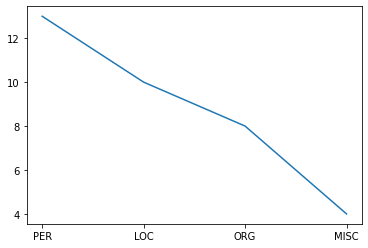

In [ ]:
import matplotlib.pyplot as plt
plt.plot(contagem_tipos);

Na noticia 0 a entidade mais presente foi do tipo pessoa, seguida de localização

<b> Atividade </b>

10) Plote um gráfico com esses dados com todos os tipos das entidades de todas as notícias. Compare este resultado com o resultado da notícia 0.

In [ ]:
tipos=[]
for j in range(0,len(texto_noticias_model)):
   for i in range(0,len(texto_noticias_model[j].ents)):
      tipos.append(texto_noticias_model[j].ents[i].label_)
print(tipos)         

['MISC', 'LOC', 'LOC', 'PER', 'ORG', 'ORG', 'PER', 'ORG', 'PER', 'LOC', 'PER', 'PER', 'PER', 'ORG', 'MISC', 'PER', 'PER', 'PER', 'MISC', 'MISC', 'LOC', 'LOC', 'LOC', 'LOC', 'PER', 'LOC', 'LOC', 'ORG', 'ORG', 'PER', 'PER', 'LOC', 'ORG', 'PER', 'ORG', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'MISC', 'ORG', 'PER', 'LOC', 'LOC', 'PER', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'PER', 'MISC', 'LOC', 'MISC', 'MISC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'PER', 'ORG', 'ORG', 'LOC', 'LOC', 'LOC', 'PER', 'PER', 'LOC', 'LOC', 'ORG', 'ORG', 'PER', 'ORG', 'PER', 'ORG', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'LOC', 'MISC', 'MISC', 'PER', 'LOC', 'LOC', 'PER', 'PER', 'ORG', 'MISC', 'PER', 'PER', 'LOC', 'PER', 'MISC', 'LOC', 'PER', 'PER', 'PER', 'PER', 'LOC', 'PER', 'MISC', 'ORG', 'PER', 'PER', 'LOC', 'LOC', 'PER', 'MISC', 'LOC', 'ORG', 'ORG', 'ORG', 'PER', 'PER', 'LOC', 'MISC', 'LOC', 'MISC', 'PER', 'MI

In [ ]:
import pandas as pd    
contagem_tipos = pd.Series(tipos).value_counts()
contagem_tipos

LOC     187
PER      85
ORG      42
MISC     38
dtype: int64

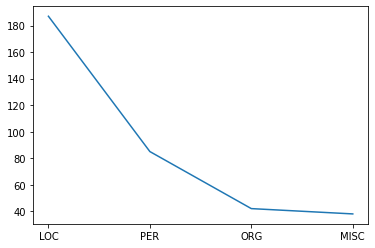

In [ ]:
import matplotlib.pyplot as plt
plt.plot(contagem_tipos);

Analisando as entidades de todas as noticias a tag localidade se destacou com 187 ocorrências. Na noticia 0 a entidade mais presente foi do tipo pessoa.

<b> Atividade </b>

11) Imprima a notícia 0, colorindo as entidades encontradas, para isto utilize o método abaixo:

```python
displacy.render(doc, jupyter=True, style='ent')
```

<i> Dica: entidades que existem no spacy https://spacy.io/api/annotation#section-named-entities 

Caso tenha dúvida sobre alguma marcalçao use:</i>

```python
spacy.explain("MISC")
```

In [ ]:
displacy.render(texto_noticias_model[0], jupyter=True, style='ent')

<b> Atividade </b>

12) Seja o documento 0 sua referência. Calcule a similaridade das entidades do documento 0 com todos outros 9. Para calcular a similaridade utilize o método jacard (implementado na aula 3). 

In [ ]:
def jaccard_similarity(lista1,lista2):
  s1 = set(lista1)
  s2 = set(lista2)
  return len(s1.intersection(s2))/len(s1.union(s2))

In [ ]:
print(jaccard_similarity(entidades[0],entidades[1]))
print(jaccard_similarity(entidades[0],entidades[2]))
print(jaccard_similarity(entidades[0],entidades[3]))
print(jaccard_similarity(entidades[0],entidades[4]))
print(jaccard_similarity(entidades[0],entidades[5]))
print(jaccard_similarity(entidades[0],entidades[6]))
print(jaccard_similarity(entidades[0],entidades[7]))
print(jaccard_similarity(entidades[0],entidades[8]))
print(jaccard_similarity(entidades[0],entidades[9]))

0.38636363636363635
0.034482758620689655
0.021739130434782608
0.0
0.03225806451612903
0.022727272727272728
0.023809523809523808
0.017241379310344827
0.38636363636363635


<b> Atividade </b>

13) Com os cálculos da questão anterior, responda: quais foram os três documentos com maior similaridade? Eles posssuem conteúdos semelhantes? E qual o documento com menor similaridade? Este documento faz sentido?

In [ ]:
entidades[0]

{'A Secretaria Estadual de Saúde de São Paulo',
 'Adolfo Lutz',
 'COE',
 'CVE',
 'Campanha Nacional de Vacinação',
 'Centro de Contingenciamento de Emergências',
 'Centro de Vigilância Epidemiológica',
 'David Uip',
 'Helena Sato',
 'Instituto Butantan',
 'Itália',
 'José Henrique Germann',
 'Menezes',
 'Milão',
 'Ministério da Saúde',
 'OMS',
 'Organização Mundial de Saúde',
 'Paulo Menezes',
 'R$',
 'Saúde',
 'Secretaria Estadual de Saúde',
 'Secretário de Estado da Saúde',
 'São Paulo',
 'Uip',
 'estado de São Paulo'}

In [ ]:
entidades[1]

{'Adolfo Lutz',
 'Alemanha',
 'Brasil',
 'COE',
 'Campanha Nacional de Vacinação',
 'Centro de Contingência',
 'Centro de Contingência de São Paulo',
 'Colômbia',
 'David Uip',
 'Einstein',
 'Espanha',
 'Europa',
 'G1',
 'Hospital Albert Einstein',
 'Hospital Beneficência Portuguesa',
 'Instituto Adolfo Lutz',
 'Itália',
 'João Doria',
 'Menezes',
 'Milão',
 'Ministério da Saúde',
 'OMS',
 'Organização Mundial de Saúde',
 'PSDB',
 'Paulo Menezes',
 'Portugal',
 'R$',
 'Saúde',
 'Secretaria Estadual de Saúde',
 'Secretaria de Saúde do Estado de São Paulo',
 'São Paulo',
 'Turim',
 'Uip',
 'Zona Sul de São Paulo',
 'estado de São Paulo',
 'Áustria'}

In [ ]:
entidades[9]

{'Adolfo Lutz',
 'Alemanha',
 'Brasil',
 'COE',
 'Campanha Nacional de Vacinação',
 'Centro de Contingência',
 'Centro de Contingência de São Paulo',
 'Colômbia',
 'David Uip',
 'Einstein',
 'Espanha',
 'Europa',
 'G1',
 'Hospital Albert Einstein',
 'Hospital Beneficência Portuguesa',
 'Instituto Adolfo Lutz',
 'Itália',
 'João Doria',
 'Menezes',
 'Milão',
 'Ministério da Saúde',
 'OMS',
 'Organização Mundial de Saúde',
 'PSDB',
 'Paulo Menezes',
 'Portugal',
 'R$',
 'Saúde',
 'Secretaria Estadual de Saúde',
 'Secretaria de Saúde do Estado de São Paulo',
 'São Paulo',
 'Turim',
 'Uip',
 'Zona Sul de São Paulo',
 'estado de São Paulo',
 'Áustria'}

In [ ]:
entidades[4]

{'Bolsofeios',
 'Bolsonaro',
 'CPMI',
 'Comissão Parlamentar Mista de Inquérito',
 'Conselho de Ética da Câmara dos Deputados',
 'Câmara',
 'Câmara dos Deputados',
 'Dudu Guimarães',
 'Eduardo',
 'Eduardo Bolsonaro',
 'Eduardo Guimarães',
 'Facebook',
 'Fake News',
 'G1',
 'Guimarães',
 'IP',
 'Instagram',
 'Jair Bolsonaro',
 'Joice',
 'Joice Hasselmann',
 'Jornal Nacional',
 'PDT-PE',
 'PSL-SP',
 'Túlio Gadelha',
 'UOL'}

Os documentos 1 e 9. Possuem assuntos/palavras semelhantes referentes a nositicias de saude dada na noticia zero, como por exemplo: itália, Brasil, secretária estadual da saúde, adolfo lutz. O documento 4 não teve similaridade com o documento zero, ele está falando sobre politica e não sobre saude.Ele não apresentou nenhum conteúdo similar ao documento 0. 

## Retreino NER

Aqui nós iremos ilustrar como treinar um modelo NER no spacy

In [ ]:
nlp = pt_core_news_sm.load()

In [ ]:
texto = "João nasceu em Paris em 01-01-2000"

In [ ]:
texto_nlp = nlp(texto)

In [ ]:
displacy.render(texto_nlp, style='ent',jupyter=True)

Observe que o modelo identifica <b> João </b> como pessoa e <b> Paris </b> como localidade.

Apesar do modelo ter identificado essas duas entidades ele naõ identificou a <b> data </b>.

Assim, aqui iremos mostrar como retreinar o modelo para capturar também a data.


In [ ]:
#dados de treino. Note que para cada frase, a posição de uma determinada entidade.
train_data = [
("Em 04/12/1992 nasceu Joana", {'entities':[(3, 13, "DATE"), (21,26, "PER")]}),
("Data de início: 10/01/2018", {'entities':[(16, 26, "DATE")]}),
("Maria se mudou para Paris", {'entities':[(20,26, "LOC")]}),
("Paris cidade das luzes", {'entities':[(0,5, "LOC")]}),    
("Maria nasceu em Contagem no dia 07/05/2018", {'entities':[(0,5,"PER"),(16,24,"LOC"),(32,42, "DATE")]})
]

### Retreino

- explosion/spaCy/master/examples/training/train_ner.py -> O spcay disponibiliza esse código para treinamentos.
- Mais informações? https://spacy.io/usage/training

In [ ]:
def train_spacy(data, iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('pt')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)           
    return nlp

In [ ]:
modelo_novo = train_spacy(train_data, 30)

In [ ]:
modelo_novo.to_disk("modelo_novo_NER")

<b> Atividade </b>

14) O ``modelo_novo`` já foi criado. Aplique o texto em que demonstramos que a data não foi identificada e depois imprima utilizando o ``displacy``.
O problema foi resolvido? E se mudarmos o formato da data, ele reconhce? Quais outras entidades o modelo não consegue reconhecer? 

In [ ]:
texto_modelo_novo = modelo_novo(texto)

In [ ]:
texto_modelo_novo

João nasceu em Paris em 01-01-2000

In [ ]:
displacy.render(texto_modelo_novo, style='ent',jupyter=True)

O problema foi resolvido. Ele reconhece outros formatos. Ele não reconhece nasceu.